# Overview
Jon Messier
2/1/2024

## Description
The National Incident-Based Reporting System is an incident-based reporting system used by law enforcement agencies in the United States for collecting and reporting data on crimes. The following reporting tool is generated from data available at the [FBI Crime Data Explorer](https://cde.ucr.cjis.gov).  This tool allows the user to explore Minnesota NIBRS data from 2018-2022 to look at the details of incidents, offenses, and offenders.

Use this jupyter-stle notebook to test out exploratory analysis before deploying via streamlit. 

# Setup and imports
Gather libraries for analysis

In [1]:
# Install the Pyscopg Postgre SQL adaptor for Python
#Use the Streamlit Virtual environment for this install

#pip install psycopg2-binary
#Documentation can be found at  https://www.psycopg.org/docs/
#It is recomended to use psycopg2 for production packages
#--->UPDATE in next .V
import psycopg2 as psg


#Import standard analysis tools
import pandas as pd
import numpy as np 
import datetime as dt


#Import graphing tools
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go 

# Notebook Functions

## `queryDB(db_name, query)`
Return pandas.dataframe of query

In [2]:
def queryDB(db_name, query):
    try:
        #establish conection to database
        conn = psg.connect(dbname=db_name, user="postgres", password="1234", host='localhost', port=5432)

        # Open a cursor to perform database operations
        # cursor class allows interaction with the database
        cur = conn.cursor()
        print("PostgreSQL server information")
        print(conn.get_dsn_parameters(), "\n")

        # Execute a query
        cur.execute(query)

        # Retrieve query results
        df = pd.DataFrame(cur.fetchall())
        df.columns = [desc[0] for desc in cur.description]
        
        
    #Collect Errors
    except (Exception) as error:
        print("Error while connecting to PostgreSQL", error)

    #Close the Connection
    finally:
        if (conn):
            cur.close()
            conn.close()
            print("PostgreSQL connection is closed")
            return(df)

# Exploratory Analysis
The NIBRS dataset is large (hundreds of gigs).  To make things easier, it has been broken down into downloadable Postgre SQL databases divided by state and year.  In this notebook I explore data from my homestate MN in 2022.  This work should be reproducible for any state and any time period(assuming data exists) as the DB structure should be the same.  

Becuase there is many different ways to load and interpret this data, I will show two example that I found interesting.  This strategy could be adopted to show other trends as needed.

### Minnesota Population statistics
Population is recorded in the NIBRS database as *agencies.population*. As part of the analysis, I want to explore the offense occurance rate per capita.  

Let's try to find : 
- [ ] Are there particular regions that have higher offense occurance rate for particular offenses?
- [ ] Does agency population size correlate to particular offenses?  Small town = small crime?
- [ ] Are big cities safer?

When looking at the state population we can take estimates from: [macrotrends.net](https://www.macrotrends.net/states/minnesota/population).  A quick look at the population between 2018 and 2022 shows that the population is fairly flat for the given range.  At a state level it population will not be a significant factor in offense occurance rates.
| Year | Population | %-change |
| --- | --- | --- |
|2022 	|5,714,300 	|-0.06%|
|2021 	|5,717,968 	|0.13%|
|2020 	|5,710,578 	|1.25%|
|2019 	|5,640,053 	|0.56%|
|2018 	|5,608,762 	|0.71%|

**Querying the DB for population**

**JOIN** *agencies* **ON** *nibrs_incident.incident_id* = *agencies.agencies_id = nibrs_incident.agencies_id*


In [3]:
q = """
    select agencies
    """

## Explore 'Offense' type frequency

NIBRS offense codes: [https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes](https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes)

Understanding how the data is collected is important when doing any analysis.  In this case, the NIBRS user manual can be found here : [https://le.fbi.gov/file-repository/nibrs-user-manual.pdf](https://le.fbi.gov/file-repository/nibrs-user-manual.pdf)

**Offense Vs. Incident** - FBI’s UCR Program defines an incident as one or more offenses committed by the same offender, or group of offenders acting in concert, at the same time and place.  That is, there can be mulitple offenses per incident.  This is important to note when considering the frequency of reported offenses.  


In [4]:
#Test Query - Lets look at the frequency of offenses by date
q = '''
    select ni.incident_date, ni.incident_hour, ni.incident_id, ni.agency_id, a.ncic_agency_name, 
	  ot.offense_code, ot.offense_name, ne.ethnicity_name, rr.race_desc, nwt.weapon_name, noff.age_num, 
	  noff.sex_code
    from nibrs_incident ni
    Right join nibrs_offense no on ni.incident_id = no.incident_id
    left join nibrs_offender noff on no.incident_id = noff.incident_id
    join nibrs_ethnicity ne on noff.ethnicity_id = ne.ethnicity_id
    join ref_race rr on noff.race_id = rr.race_id
    join agencies a on ni.agency_id = a.agency_id
    left join nibrs_weapon nw on no.offense_id = nw.offense_id
    left join nibrs_weapon_type nwt on nw.weapon_id=nwt.weapon_id
	join nibrs_offense_type ot on no.offense_type_id = ot.offense_type_id
    '''

df = queryDB("MN2020", q)
print(f"Dataframe Shape: {df.shape}")
df.head()

PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2020', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed
Dataframe Shape: (86831, 12)


incident_date  incident_hour  incident_id  agency_id       ncic_agency_name  \
0    2020-05-31             17    125111116       9188          ALEXANDRIA PD   
1    2020-10-20              5    129976152       9112             FRIDLEY PD   
2    2020-09-01             18    129976156      25610                          
3    2020-09-01             18    129976156      25610                          
4    2020-07-01              0    125611806       9284  MC LEOD CO SO GLENCOE   

  offense_code                              offense_name  \
0          250                    Counterfeiting/Forgery   
1          290  Destruction/Damage/Vandalism of Property   
2          13A                        Aggravated Assault   
3          290  Destruction/Damage/Vandalism of Property   
4          35A                  Drug/Narcotic Violations   

           ethnicity_name race_desc           weapon_name  age_num sex_code  
0  Not Hispanic or Latino     White                  None     52.0        F  
1  Not Hispanic or Latino     White                  None     48.0        M  
2                 Unknown   Unknown  Motor Vehicle/Vessel     22.0        M  
3                 Unknown   Unknown                  None     22.0        M  
4                 Unknown   Unknown                  None     20.0        F

In [5]:
#Add the weekday
# Convert the integer to english representation
df['weekday'] = df["incident_date"].dt.strftime("%A")
df.head()

incident_date  incident_hour  incident_id  agency_id       ncic_agency_name  \
0    2020-05-31             17    125111116       9188          ALEXANDRIA PD   
1    2020-10-20              5    129976152       9112             FRIDLEY PD   
2    2020-09-01             18    129976156      25610                          
3    2020-09-01             18    129976156      25610                          
4    2020-07-01              0    125611806       9284  MC LEOD CO SO GLENCOE   

  offense_code                              offense_name  \
0          250                    Counterfeiting/Forgery   
1          290  Destruction/Damage/Vandalism of Property   
2          13A                        Aggravated Assault   
3          290  Destruction/Damage/Vandalism of Property   
4          35A                  Drug/Narcotic Violations   

           ethnicity_name race_desc           weapon_name  age_num sex_code  \
0  Not Hispanic or Latino     White                  None     52.0        F   
1  Not Hispanic or Latino     White                  None     48.0        M   
2                 Unknown   Unknown  Motor Vehicle/Vessel     22.0        M   
3                 Unknown   Unknown                  None     22.0        M   
4                 Unknown   Unknown                  None     20.0        F   

     weekday  
0     Sunday  
1    Tuesday  
2    Tuesday  
3    Tuesday  
4  Wednesday

In [6]:
#take a look at which incident type is occuring most freq.
df["offense_name"].value_counts()

offense_name
Drug/Narcotic Violations                       13057
Simple Assault                                 10884
Shoplifting                                     9758
Destruction/Damage/Vandalism of Property        6695
Drug Equipment Violations                       5851
All Other Larceny                               4351
Aggravated Assault                              4257
Intimidation                                    4178
Weapon Law Violations                           3375
Burglary/Breaking & Entering                    3200
Stolen Property Offenses                        2915
Motor Vehicle Theft                             2415
Counterfeiting/Forgery                          1837
Theft From Building                             1734
Theft From Motor Vehicle                        1715
False Pretenses/Swindle/Confidence Game         1635
Robbery                                         1428
Credit Card/Automated Teller Machine Fraud      1354
Identity Theft                   

In [7]:
q = """
    select distinct offense_code, offense_name
    from nibrs_offense_type
    """
offense_names = queryDB(db_name="MN2022", query=q)
offense_names

PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2022', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed


offense_code                  offense_name
0           103                     Espionage
1           210           Extortion/Blackmail
2           510                       Bribery
3           61B      Federal Tobacco Offenses
4           220  Burglary/Breaking & Entering
..          ...                           ...
81          720                Animal Cruelty
82          30B             False Citizenship
83          26D                 Welfare Fraud
84          09B        Negligent Manslaughter
85          23F      Theft From Motor Vehicle

[86 rows x 2 columns]

In [8]:
#overall incident trend
trend = df.groupby("incident_date")["incident_id"].count()

### Agency data

In [9]:
agencies = df.groupby("ncic_agency_name")["incident_id"].count().nlargest(1)
print(agencies)
print(agencies.index[0])
print(agencies[0])

ncic_agency_name
MINNEAPOLIS PD    7246
Name: incident_id, dtype: int64
MINNEAPOLIS PD
7246


C:\Users\jonme\AppData\Local\Temp\ipykernel_9740\2633487369.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(agencies[0])


## Filter for Offense code = 290

In [10]:
#filter for type 290
filter = df[df["offense_code"]=="290"].copy()
filter.head()

incident_date  incident_hour  incident_id  agency_id  \
1     2020-10-20              5    129976152       9112   
3     2020-09-01             18    129976156      25610   
31    2020-07-03              2    125612279       9311   
52    2020-12-26             18    132618795       9323   
71    2020-08-27              1    133347333       9255   

             ncic_agency_name offense_code  \
1                  FRIDLEY PD          290   
3                                      290   
31             WORTHINGTON PD          290   
52       POLK CO SO CROOKSTON          290   
71  ITASCA CO SO GRAND RAPIDS          290   

                                offense_name          ethnicity_name  \
1   Destruction/Damage/Vandalism of Property  Not Hispanic or Latino   
3   Destruction/Damage/Vandalism of Property                 Unknown   
31  Destruction/Damage/Vandalism of Property      Hispanic or Latino   
52  Destruction/Damage/Vandalism of Property  Not Hispanic or Latino   
71  Destruction/Damage/Vandalism of Property  Not Hispanic or Latino   

                           race_desc weapon_name  age_num sex_code   weekday  
1                              White        None     48.0        M   Tuesday  
3                            Unknown        None     22.0        M   Tuesday  
31                             White        None     21.0        F    Friday  
52                             White        None     20.0        M  Saturday  
71  American Indian or Alaska Native        None     25.0        M  Thursday

### Time trends

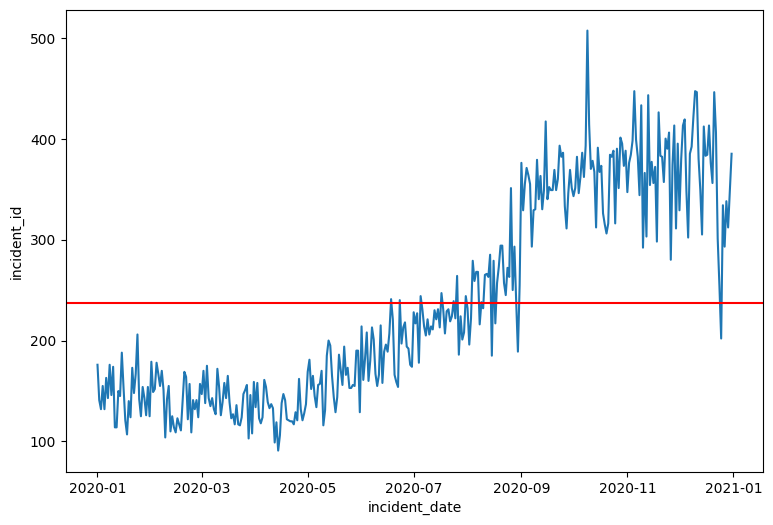

In [11]:
fig, axes = plt.subplots(figsize=(9,6))
sns.lineplot(data = trend)
plt.axhline(trend.mean(), color='red')

In [12]:
trend_290 = df[df["offense_code"]=="290"].groupby("incident_date")["incident_id"].count()

<Axes: xlabel='incident_date', ylabel='incident_id'>

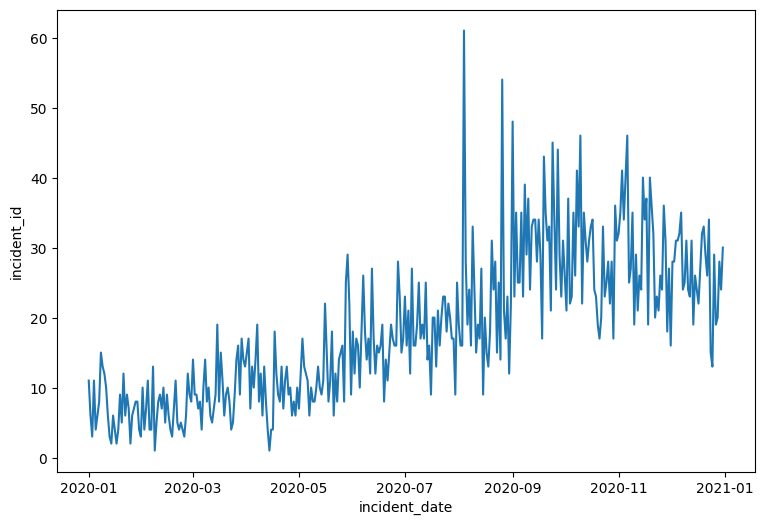

In [13]:
fig, axes = plt.subplots(figsize=(9,6))
sns.lineplot(data = trend_290)

### Does the weekday matter?

In [14]:
fig1 = px.histogram(data_frame=filter[["incident_id", "weekday"]], x="weekday", y="incident_id", histfunc='count')
fig1.show()

### Does the time matter?

In [15]:
fig2 = px.histogram(data_frame=filter[["incident_id", "incident_hour"]], x="incident_hour", y="incident_id", histfunc='count')
fig2.show()

### Plot  Race / Weapons used / drugs?

In [16]:
df.groupby("race_desc")["incident_id"].count()

race_desc
American Indian or Alaska Native              4473
Asian                                         1706
Black or African American                    24124
Native Hawaiian or Other Pacific Islander      140
Unknown                                      14494
White                                        41894
Name: incident_id, dtype: int64

In [17]:
fig = px.pie(data_frame=df[["incident_id","race_desc"]], names='race_desc', values='incident_id' )
fig.show()

In [18]:
filter[["incident_id","race_desc"]]

incident_id                                  race_desc
1        129976152                                      White
3        129976156                                    Unknown
31       125612279                                      White
52       132618795                                      White
71       133347333           American Indian or Alaska Native
...            ...                                        ...
86767    135698330                                    Unknown
86775    135780405                  Black or African American
86811    135214990                  Black or African American
86822    135613122                                      White
86824    133519215  Native Hawaiian or Other Pacific Islander

[6695 rows x 2 columns]

In [22]:
#print(filter['race'].unique())
race_pie = filter['race_desc'].value_counts()
print(filter['race_desc'].unique())
print(race_pie.values[:])

['Unknown' 'Black or African American' 'White'
 'American Indian or Alaska Native' 'Asian'
 'Native Hawaiian or Other Pacific Islander']
[1747 1740  429  259   76    6]


### Weapon

In [20]:
# No weapon incidents recored for offense code = 290 - Destruction/Damage/Vandalism of Property
#Change filter to type 13A - Aggrevated Assault
filter = df[df["offense_code"]=="13A"].copy()
filter.groupby('weapon_name')['incident_id'].count().sort_values(ascending=False)

weapon_name
Personal Weapons                  959
Knife/Cutting Instrument          928
Handgun                           504
Blunt Object                      466
Other                             356
None                              210
Firearm                           195
Motor Vehicle/Vessel              191
Asphyxiation                      101
Handgun (Automatic)                93
Unknown                            91
Other Firearm                      51
Firearm (Automatic)                38
Shotgun                            27
Rifle                              21
Fire/Incendiary Device              9
Other Firearm (Automatic)           4
Shotgun (Automatic)                 4
Drugs/Narcotics/Sleeping Pills      3
Poison                              3
Explosives                          2
Rifle (Automatic)                   1
Name: incident_id, dtype: int64

In [23]:
# Weapon pie chart
#fig2 = px.histogram(data_frame=filter[["incident", "hour"]], x="hour", y="incident", histfunc='count')
fig = px.pie(data_frame=filter[["incident_id","weapon_name"]], names='weapon_name', values='incident_id' )
fig.show()

## Victim Analysis


## Cummulative Offense Type Trends over time analysis
- [ ] gather incident_id, incident_date, offense_name/offense_desc for 2018-2022

In [24]:
#2021-2022 query
q=  """
    select ni.incident_date, ni.incident_id, a.ncic_agency_name, ot.offense_name, ot.offense_code
    from nibrs_incident ni
    Right join nibrs_offense no on ni.incident_id = no.incident_id
    join agencies a on ni.agency_id = a.agency_id
    join nibrs_offense_type ot on no.offense_code = ot.offense_code
    """

mn2022 = queryDB(db_name="MN2022", query=q)
mn2021 = queryDB(db_name="MN2021", query=q)

# The scehma changes dates<2021
q = """
    select ni.incident_date, ni.incident_id, a.ncic_agency_name, ot.offense_name, ot.offense_code
    from nibrs_incident ni
    Right join nibrs_offense no on ni.incident_id = no.incident_id
    join agencies a on ni.agency_id = a.agency_id
    join nibrs_offense_type ot on no.offense_type_id = ot.offense_type_id
    """
mn2020 = queryDB(db_name="MN2020", query=q)
mn2019 = queryDB(db_name="MN2019", query=q)
mn2018 = queryDB(db_name="MN2018", query=q)

PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2022', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed
PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2021', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed
PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2020', 'host': 'l

In [25]:
#combine the data into 1 dataframe
df = pd.concat([mn2018, mn2019, mn2020, mn2021, mn2022])
print(df.shape)
df.head()

(817392, 5)


incident_date  incident_id          ncic_agency_name  \
0    2018-11-30    116298684  BLUE EARTH CO SO MANKATO   
1    2018-02-01    117310335               RED WING PD   
2    2018-05-07    116299949                MANKATO PD   
3    2018-10-29    116399342               FAIRMONT PD   
4    2018-12-19    116439906                    WASECA   

                   offense_name offense_code  
0  Burglary/Breaking & Entering          220  
1                          Rape          11A  
2      Drug/Narcotic Violations          35A  
3                Simple Assault          13B  
4  Pornography/Obscene Material          370

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 817392 entries, 0 to 257018
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   incident_date     817392 non-null  datetime64[ns]
 1   incident_id       817392 non-null  int64         
 2   ncic_agency_name  804898 non-null  object        
 3   offense_name      817392 non-null  object        
 4   offense_code      817392 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 37.4+ MB


In [27]:
#take a look at which incident type is occuring most freq.
df["offense_name"].value_counts()

offense_name
Destruction/Damage/Vandalism of Property       103063
All Other Larceny                               87060
Simple Assault                                  65677
Theft From Motor Vehicle                        63824
Drug/Narcotic Violations                        61297
Shoplifting                                     56431
Motor Vehicle Theft                             46242
Burglary/Breaking & Entering                    46004
Theft of Motor Vehicle Parts or Accessories     33107
Aggravated Assault                              26959
Intimidation                                    26902
Drug Equipment Violations                       26383
Theft From Building                             22591
False Pretenses/Swindle/Confidence Game         21454
Weapon Law Violations                           19601
Credit Card/Automated Teller Machine Fraud      18541
Identity Theft                                  17532
Stolen Property Offenses                        13644
Counterfeiting/

In [28]:
#Group the data by name, and date then count the number of occurances
trends = df.groupby(["offense_name","incident_date"])["incident_id"].count().unstack()
trends = trends.transpose()

In [29]:
trends.head()

offense_name   Aggravated Assault  All Other Larceny  Animal Cruelty  Arson  \
incident_date                                                                 
2018-01-01                    2.0                2.0             NaN    NaN   
2018-01-02                    1.0                1.0             NaN    NaN   
2018-01-03                    1.0                2.0             NaN    NaN   
2018-01-04                    NaN                6.0             NaN    NaN   
2018-01-05                    1.0                1.0             NaN    NaN   

offense_name   Assisting or Promoting Prostitution  Betting/Wagering  Bribery  \
incident_date                                                                   
2018-01-01                                     NaN               NaN      NaN   
2018-01-02                                     NaN               NaN      NaN   
2018-01-03                                     NaN               NaN      NaN   
2018-01-04                                     NaN               NaN      NaN   
2018-01-05                                     NaN               NaN      NaN   

offense_name   Burglary/Breaking & Entering  Counterfeiting/Forgery  \
incident_date                                                         
2018-01-01                              4.0                     NaN   
2018-01-02                              3.0                     1.0   
2018-01-03                              NaN                     2.0   
2018-01-04                              3.0                     2.0   
2018-01-05                              2.0                     1.0   

offense_name   Credit Card/Automated Teller Machine Fraud  ...  \
incident_date                                              ...   
2018-01-01                                            NaN  ...   
2018-01-02                                            1.0  ...   
2018-01-03                                            NaN  ...   
2018-01-04                                            1.0  ...   
2018-01-05                                            3.0  ...   

offense_name   Sports Tampering  Statutory Rape  Stolen Property Offenses  \
incident_date                                                               
2018-01-01                  NaN             1.0                       NaN   
2018-01-02                  NaN             NaN                       NaN   
2018-01-03                  NaN             NaN                       NaN   
2018-01-04                  NaN             NaN                       NaN   
2018-01-05                  NaN             NaN                       NaN   

offense_name   Theft From Building  \
incident_date                        
2018-01-01                     1.0   
2018-01-02                     1.0   
2018-01-03                     1.0   
2018-01-04                     1.0   
2018-01-05                     2.0   

offense_name   Theft From Coin-Operated Machine or Device  \
incident_date                                               
2018-01-01                                            NaN   
2018-01-02                                            NaN   
2018-01-03                                            NaN   
2018-01-04                                            NaN   
2018-01-05                                            NaN   

offense_name   Theft From Motor Vehicle  \
incident_date                             
2018-01-01                          2.0   
2018-01-02                          NaN   
2018-01-03                          NaN   
2018-01-04                          3.0   
2018-01-05                          NaN   

offense_name   Theft of Motor Vehicle Parts or Accessories  \
incident_date                                                
2018-01-01                                             1.0   
2018-01-02                                             NaN   
2018-01-03                                             NaN   
2018-01-04                                             NaN   
2018-01-

<Axes: xlabel='incident_date'>

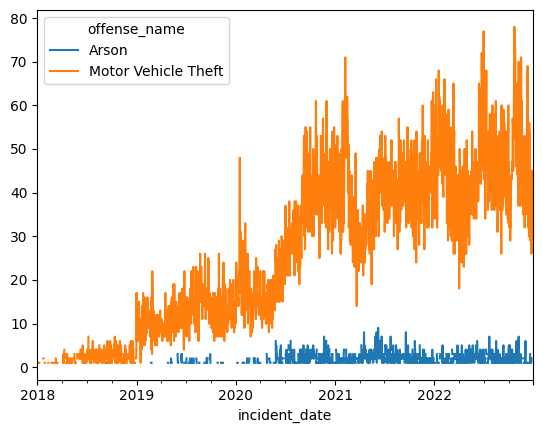

In [30]:
trends.plot(y=["Arson", "Motor Vehicle Theft"])

### Use a Rolling Average
I use a monthly rolling average to smooth out the noisy occurance data.  The rolling mean give a good approximation of the trend.  

In [31]:
# Create a rolling average
for col in trends.columns:
    col_roll = col+'_avg'
    #30 day rolling average
    trends[col_roll] = trends[col].rolling(30).mean()

In [32]:
trends.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='incident_date', length=1826, freq=None)

In [33]:
trends.loc['2021-1-01']

offense_name
Aggravated Assault                                 27.000000
All Other Larceny                                  56.000000
Animal Cruelty                                      1.000000
Arson                                               1.000000
Assisting or Promoting Prostitution                      NaN
                                                     ...    
Theft From Motor Vehicle_avg                       65.100000
Theft of Motor Vehicle Parts or Accessories_avg    30.733333
Weapon Law Violations_avg                          14.400000
Welfare Fraud_avg                                        NaN
Wire Fraud_avg                                           NaN
Name: 2021-01-01 00:00:00, Length: 104, dtype: float64

In [34]:
#mask= (trends.loc['2021-1-01'] & trends.loc['2022-1-01'])

print(f"Date: {trends.loc['2021-1-01':'2022-1-01']['Motor Vehicle Theft'].idxmax()}, Max Val: {trends.loc['2021-1-01':'2022-1-01']['Motor Vehicle Theft'].max()}")

Date: 2021-02-07 00:00:00, Max Val: 71.0


<Axes: xlabel='incident_date'>

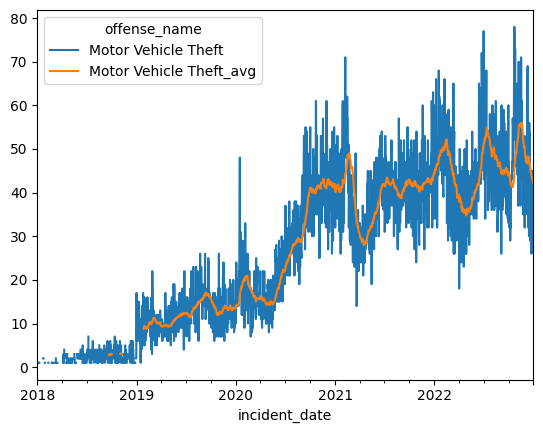

In [35]:
#Compare the smoothed vs. unsmoothed data
trends.plot(y=["Motor Vehicle Theft","Motor Vehicle Theft_avg"])

<Axes: xlabel='incident_date'>

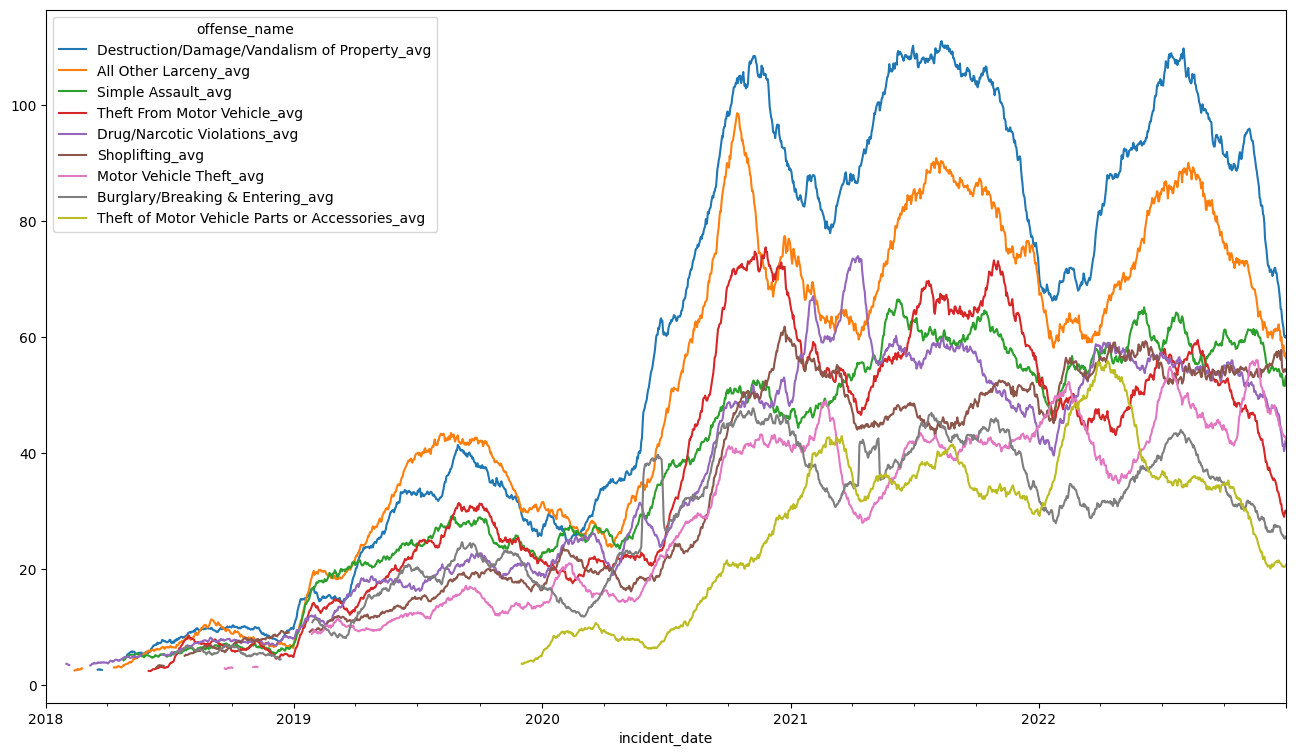

In [36]:
#Plot the 30-day moving average of the top ten offenses (ranked by cumulative occurance) 
trends.plot(y=["Destruction/Damage/Vandalism of Property_avg",
            'All Other Larceny_avg',
            'Simple Assault_avg',
            'Theft From Motor Vehicle_avg',
            'Drug/Narcotic Violations_avg',
            'Shoplifting_avg',
            'Motor Vehicle Theft_avg',
            'Burglary/Breaking & Entering_avg',
            'Theft of Motor Vehicle Parts or Accessories_avg'], figsize = (16,9))

## Weapon usage over time

In [37]:
q = """
    select ni.incident_date, nwt.weapon_name, ni.incident_id
    from nibrs_incident ni
    Right join nibrs_offense no on ni.incident_id = no.incident_id
    left join nibrs_weapon nw on no.offense_id = nw.offense_id
    left join nibrs_weapon_type nwt on nw.weapon_id=nwt.weapon_id
    """

w18 = queryDB("MN2018", q)
w19 = queryDB("MN2019", q)
w20 = queryDB("MN2020", q)
w21 = queryDB("MN2021", q)
w22 = queryDB("MN2022", q)

PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2018', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed
PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2019', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed
PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2020', 'host': 'l

In [38]:
weapons = pd.concat([w18,w19,w20,w21,w22])

In [39]:
weapons.weapon_name.unique()

array([None, 'Personal Weapons', 'None', 'Other', 'Asphyxiation',
       'Blunt Object', 'Other Firearm', 'Unknown', 'Handgun',
       'Knife/Cutting Instrument', 'Firearm', 'Shotgun', 'Rifle',
       'Handgun (Automatic)', 'Motor Vehicle/Vessel', 'Rifle (Automatic)',
       'Drugs/Narcotics/Sleeping Pills', 'Fire/Incendiary Device',
       'Explosives', 'Firearm (Automatic)', 'Shotgun (Automatic)',
       'Poison', 'Other Firearm (Automatic)'], dtype=object)

In [40]:
weapons.groupby(["weapon_name"])['incident_id'].count()

weapon_name
Asphyxiation                        548
Blunt Object                       3200
Drugs/Narcotics/Sleeping Pills      190
Explosives                          485
Fire/Incendiary Device              145
Firearm                            8777
Firearm (Automatic)                 518
Handgun                           15196
Handgun (Automatic)                1910
Knife/Cutting Instrument           7358
Motor Vehicle/Vessel               1318
None                              17860
Other                             10278
Other Firearm                      1214
Other Firearm (Automatic)            46
Personal Weapons                  68318
Poison                               27
Rifle                               925
Rifle (Automatic)                    87
Shotgun                             966
Shotgun (Automatic)                  38
Unknown                            4826
Name: incident_id, dtype: int64

In [41]:
weapon_trend = weapons.groupby(["weapon_name",'incident_date'])['incident_id'].count().unstack()
weapon_trend = weapon_trend.transpose()

In [42]:
weapon_trend.head()

weapon_name    Asphyxiation  Blunt Object  Drugs/Narcotics/Sleeping Pills  \
incident_date                                                               
2018-03-07              1.0           NaN                             NaN   
2018-04-18              1.0           NaN                             NaN   
2018-04-19              1.0           NaN                             NaN   
2018-04-22              1.0           NaN                             NaN   
2018-05-09              1.0           NaN                             NaN   

weapon_name    Explosives  Fire/Incendiary Device  Firearm  \
incident_date                                                
2018-03-07            NaN                     NaN      1.0   
2018-04-18            NaN                     NaN      NaN   
2018-04-19            NaN                     NaN      NaN   
2018-04-22            NaN                     NaN      2.0   
2018-05-09            NaN                     NaN      NaN   

weapon_name    Firearm (Automatic)  Handgun  Handgun (Automatic)  \
incident_date                                                      
2018-03-07                     NaN      NaN                  NaN   
2018-04-18                     NaN      NaN                  NaN   
2018-04-19                     NaN      NaN                  NaN   
2018-04-22                     NaN      NaN                  NaN   
2018-05-09                     NaN      1.0                  NaN   

weapon_name    Knife/Cutting Instrument  ...  Other  Other Firearm  \
incident_date                            ...                         
2018-03-07                          2.0  ...    NaN            NaN   
2018-04-18                          NaN  ...    NaN            NaN   
2018-04-19                          2.0  ...    1.0            NaN   
2018-04-22                          NaN  ...    1.0            NaN   
2018-05-09                          1.0  ...    NaN            1.0   

weapon_name    Other Firearm (Automatic)  Personal Weapons  Poison  Rifle  \
incident_date                                                               
2018-03-07                           NaN               2.0     NaN    NaN   
2018-04-18                           NaN               5.0     NaN    NaN   
2018-04-19                           NaN               6.0     NaN    NaN   
2018-04-22                           NaN               6.0     NaN    NaN   
2018-05-09                           NaN               7.0     NaN    NaN   

weapon_name    Rifle (Automatic)  Shotgun  Shotgun (Automatic)  Unknown  
incident_date                                                            
2018-03-07                   NaN      NaN                  NaN      NaN  
2018-04-18                   NaN      NaN                  NaN      NaN  
2018-04-19                   NaN      NaN                  NaN      NaN  
2018-04-22                   NaN      NaN                  NaN      NaN  
2018-05-09                   NaN      NaN                  NaN      NaN  

[5 rows x 22 columns]

In [43]:
for col in weapon_trend.columns:
    col_roll = col+'_avg'
    #30 day rolling average
    weapon_trend[col_roll] =  weapon_trend[col].rolling(30).mean()

<Axes: xlabel='incident_date'>

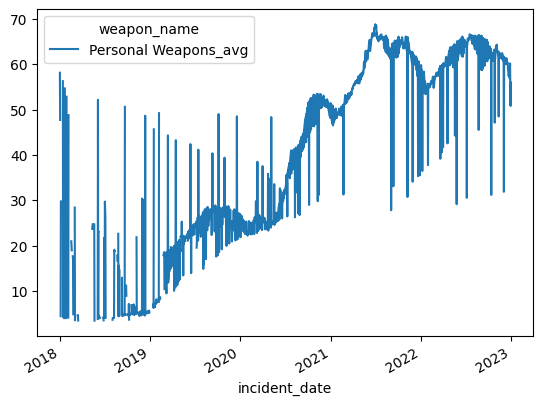

In [44]:
weapon_trend.plot(y=['Personal Weapons_avg'])

## Agency Comparison
Use the *agencies.agency_id*, *agencies.population*, and *agencies.ori* to group and analyze offenses and population densities.

In [45]:
q = """
    select ni.data_year, ni.incident_id, a.ncic_agency_name, ot.offense_name, ot.offense_code, a.population, a.ori
    from nibrs_incident ni
    Right join nibrs_offense no on ni.incident_id = no.incident_id
    join agencies a on ni.agency_id = a.agency_id
    join nibrs_offense_type ot on no.offense_type_id = ot.offense_type_id
    """
a18 = queryDB("MN2018", q)
a19 = queryDB("MN2019", q)
a20 = queryDB("MN2020", q)


q = """
    select ni.data_year, ni.incident_id, a.ncic_agency_name, ot.offense_name, ot.offense_code, a.population, a.ori
    from nibrs_incident ni
    Right join nibrs_offense no on ni.incident_id = no.incident_id
    join agencies a on ni.agency_id = a.agency_id
    join nibrs_offense_type ot on no.offense_code = ot.offense_code
    """
a21 = queryDB("MN2021", q)
a22 = queryDB("MN2022", q)

df = pd.concat([a18,a19,a20,a21,a22])
df.head()

PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2018', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed
PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2019', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

PostgreSQL connection is closed
PostgreSQL server information
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'MN2020', 'host': 'l

data_year  incident_id          ncic_agency_name  \
0       2018    116298684  BLUE EARTH CO SO MANKATO   
1       2018    117310335               RED WING PD   
2       2018    116299949                MANKATO PD   
3       2018    116399342               FAIRMONT PD   
4       2018    116439906                    WASECA   

                   offense_name offense_code  population        ori  
0  Burglary/Breaking & Entering          220       14837  MN0070000  
1                          Rape          11A       16405  MN0250300  
2      Drug/Narcotic Violations          35A       42606  MN0070100  
3                Simple Assault          13B       10053  MN0460100  
4  Pornography/Obscene Material          370        6359  MN0810000

### Examine Populations

In [113]:
#Get a non-duplicated list of agency::data_year::pop
populations = df[['ncic_agency_name','data_year','population']].drop_duplicates()
#set the index to be searchable by agency name and year
populations.set_index(['ncic_agency_name','data_year'],inplace=True)
#populations.head()

In [117]:
populations.shape

(1402, 1)

In [118]:
#sample data
populations.loc['RED WING PD',2018].population

C:\Users\jonme\AppData\Local\Temp\ipykernel_9740\2824337761.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



ncic_agency_name  data_year
RED WING PD       2018         16405
Name: population, dtype: int64

In [123]:
16405/populations.loc['RED WING PD',2018].population

C:\Users\jonme\AppData\Local\Temp\ipykernel_9740\3756881618.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



ncic_agency_name  data_year
RED WING PD       2018         1.0
Name: population, dtype: float64

### Annual Offense data

In [46]:
annual = df.groupby(["ncic_agency_name",'data_year','offense_name'])["incident_id"].count().sort_values(ascending=False).unstack()
annual.head()

offense_name                   Aggravated Assault  All Other Larceny  \
ncic_agency_name    data_year                                          
                    2018                     11.0               29.0   
                    2019                     20.0              142.0   
                    2020                    100.0              420.0   
AITKIN CO SO AITKIN 2019                      6.0               75.0   
                    2020                     13.0              118.0   

offense_name                   Animal Cruelty  Arson  \
ncic_agency_name    data_year                          
                    2018                  1.0    2.0   
                    2019                  3.0    NaN   
                    2020                  1.0   11.0   
AITKIN CO SO AITKIN 2019                  2.0    NaN   
                    2020                  1.0    2.0   

offense_name                   Assisting or Promoting Prostitution  \
ncic_agency_name    data_year                                        
                    2018                                       NaN   
                    2019                                       NaN   
                    2020                                       NaN   
AITKIN CO SO AITKIN 2019                                       NaN   
                    2020                                       NaN   

offense_name                   Betting/Wagering  Bribery  \
ncic_agency_name    data_year                              
                    2018                    NaN      NaN   
                    2019                    NaN      NaN   
                    2020                    1.0      1.0   
AITKIN CO SO AITKIN 2019                    NaN      NaN   
                    2020                    NaN      NaN   

offense_name                   Burglary/Breaking & Entering  \
ncic_agency_name    data_year                                 
                    2018                               18.0   
                    2019                               54.0   
                    2020                               82.0   
AITKIN CO SO AITKIN 2019                               57.0   
                    2020                               89.0   

offense_name                   Counterfeiting/Forgery  \
ncic_agency_name    data_year                           
                    2018                          5.0   
                    2019                         21.0   
                    2020                         55.0   
AITKIN CO SO AITKIN 2019                          7.0   
                    2020                          6.0   

offense_name                   Credit Card/Automated Teller Machine Fraud  \
ncic_agency_name    data_year                                               
                    2018                                              4.0   
                    2019                                              5.0   
                    2020                                             13.0   
AITKIN CO SO AITKIN 2019                                             10.0   
                    2020                                              4.0   

offense_name                   ...  Sports Tampering  Statutory Rape  \
ncic_agency_name    data_year  ...                                     
                    2018       ...               NaN             NaN   
                    2019       ...               NaN             NaN   
                    2020       ...               NaN             NaN   
AITKIN CO SO AITKIN 2019       ...               NaN             NaN   
                    2020       ...               NaN             NaN   

offense_name                   Stolen Property Offenses  Theft From Building  \
ncic_agency_name    data_year                                                  
                    2018                            3.0                 20.0   
                    2019                            6.0        

In [61]:
annual.columns

Index(['Aggravated Assault', 'All Other Larceny', 'Animal Cruelty', 'Arson',
       'Assisting or Promoting Prostitution', 'Betting/Wagering', 'Bribery',
       'Burglary/Breaking & Entering', 'Counterfeiting/Forgery',
       'Credit Card/Automated Teller Machine Fraud',
       ...
       'Sports Tampering_norm', 'Statutory Rape_norm',
       'Stolen Property Offenses_norm', 'Theft From Building_norm',
       'Theft From Coin-Operated Machine or Device_norm',
       'Theft From Motor Vehicle_norm',
       'Theft of Motor Vehicle Parts or Accessories_norm',
       'Weapon Law Violations_norm', 'Welfare Fraud_norm', 'Wire Fraud_norm'],
      dtype='object', name='offense_name', length=104)

In [62]:
annual.index

MultiIndex([(                                   '', 2018),
            (                                   '', 2019),
            (                                   '', 2020),
            (                'AITKIN CO SO AITKIN', 2019),
            (                'AITKIN CO SO AITKIN', 2020),
            (                'AITKIN CO SO AITKIN', 2021),
            (                'AITKIN CO SO AITKIN', 2022),
            (                          'ALBANY PD', 2021),
            (                          'ALBANY PD', 2022),
            (                      'ALBERT LEA PD', 2018),
            ...
            (                         'WYOMING PD', 2021),
            (                         'WYOMING PD', 2022),
            ('YELLOW MEDICINE CO SO GRANITE FALLS', 2020),
            ('YELLOW MEDICINE CO SO GRANITE FALLS', 2021),
            ('YELLOW MEDICINE CO SO GRANITE FALLS', 2022),
            (                        'ZUMBROTA PD', 2018),
            (                        'ZU

In [72]:
annual.index.names

FrozenList(['ncic_agency_name', 'data_year'])

In [69]:
#Multi-index searchable via ncic_agency_name
annual.loc["ZUMBROTA PD"]

offense_name  Aggravated Assault  All Other Larceny  Animal Cruelty  Arson  \
data_year                                                                    
2018                         1.0               14.0             NaN    NaN   
2019                         1.0               15.0             NaN    NaN   
2020                         NaN               12.0             NaN    NaN   
2021                         3.0               13.0             NaN    NaN   
2022                         1.0                1.0             NaN    NaN   

offense_name  Assisting or Promoting Prostitution  Betting/Wagering  Bribery  \
data_year                                                                      
2018                                          NaN               NaN      NaN   
2019                                          NaN               NaN      NaN   
2020                                          NaN               NaN      NaN   
2021                                          NaN               NaN      NaN   
2022                                          NaN               NaN      NaN   

offense_name  Burglary/Breaking & Entering  Counterfeiting/Forgery  \
data_year                                                            
2018                                  10.0                    11.0   
2019                                   5.0                     9.0   
2020                                   2.0                     5.0   
2021                                   1.0                     4.0   
2022                                   1.0                     NaN   

offense_name  Credit Card/Automated Teller Machine Fraud  ...  \
data_year                                                 ...   
2018                                                 4.0  ...   
2019                                                 1.0  ...   
2020                                                 4.0  ...   
2021                                                 NaN  ...   
2022                                                 2.0  ...   

offense_name  Sports Tampering_norm  Statutory Rape_norm  \
data_year                                                  
2018                            NaN                  NaN   
2019                            NaN                  NaN   
2020                            NaN                  NaN   
2021                            NaN                  NaN   
2022                            NaN                  NaN   

offense_name  Stolen Property Offenses_norm  Theft From Building_norm  \
data_year                                                               
2018                                    NaN                       0.5   
2019                                    0.1                       0.1   
2020                                    0.2                       0.5   
2021                                    NaN                       NaN   
2022                                    NaN                       0.1   

offense_name  Theft From Coin-Operated Machine or Device_norm  \
data_year                                                       
2018                                                      NaN   
2019                                                      NaN   
2020                                                      0.1   
2021                                                      NaN   
2022                                                      NaN   

offense_name  Theft From Motor Vehicle_norm  \
data_year                                     
2018                                    1.1   
2019                                    1.3   
2020                                    0.7   
2021                                    0.7   
2022                                    0.5   

offense_name  Theft of Motor Vehicle Parts or Accessories_norm  \
data_year                                                        
2018                                                       0.2   
2019                        

In [70]:
#Multi-index searchable via ncic_agency_name and year
annual.loc["ZUMBROTA PD",2018]

offense_name
Aggravated Assault                                   1.0
All Other Larceny                                   14.0
Animal Cruelty                                       NaN
Arson                                                NaN
Assisting or Promoting Prostitution                  NaN
                                                    ... 
Theft From Motor Vehicle_norm                        1.1
Theft of Motor Vehicle Parts or Accessories_norm     0.2
Weapon Law Violations_norm                           0.1
Welfare Fraud_norm                                   NaN
Wire Fraud_norm                                      NaN
Name: (ZUMBROTA PD, 2018), Length: 104, dtype: float64

In [82]:
#get the list of agency names
annual.index.unique(level='ncic_agency_name')

Index(['', 'AITKIN CO SO AITKIN', 'ALBANY PD', 'ALBERT LEA PD',
       'ALEXANDRIA PD', 'ANNANDALE PD', 'ANOKA CO SO ANOKA', 'ANOKA PD',
       'APPLE VALLEY PD', 'APPLETON PD',
       ...
       'WINNEBAGO PD', 'WINONA CO SO WINONA', 'WINONA PD', 'WINSTED PD',
       'WOODBURY PD', 'WORTHINGTON PD', 'WRIGHT CO SO BUFFALO', 'WYOMING PD',
       'YELLOW MEDICINE CO SO GRANITE FALLS', 'ZUMBROTA PD'],
      dtype='object', name='ncic_agency_name', length=322)

In [94]:
annual.index.unique(level='data_year')

Index([2018, 2019, 2020, 2021, 2022], dtype='int64', name='data_year')

In [121]:
annual.loc["ZUMBROTA PD",2018].values/populations.loc["ZUMBROTA PD",2018].population

C:\Users\jonme\AppData\Local\Temp\ipykernel_9740\1546013210.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



ValueError: Length of values (104) does not match length of index (1)

In [ ]:
for name in annual.index.unique(level='ncic_agency_name'):
    for year in annual.index.unique(level='data_year'):
        